### GRU based encoder and Attention based decoder after Luong for Vietnamese-English translation

In [1]:
### Load all the libraries

from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import pickle
from typing import List
from collections import Counter, namedtuple
from itertools import zip_longest

from torch.autograd import Variable

plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np
%matplotlib inline
from torch.utils.data import Dataset

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.nn import functional

import torch
from torch.nn import functional
from torch.autograd import Variable

import io

import time
import math

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
USE_CUDA = torch.cuda.is_available()

MAX_LENGTH = 30 #maximum sentence length

MAX_VOCAB_SIZE = 50000 #maximum vocabulary size

PAD_IDX = 0 
SOS_IDX = 1
EOS_IDX = 2
UNK_IDX = 3

In [2]:
# Check CUDA is available
USE_CUDA

True

In [34]:
### Code references: https://github.com/spro/practical-pytorch/blob/master/seq2seq-translation/seq2seq-translation-batched.ipynb?fbclid=IwAR0LRHAIXhvRqewTXayFLEdr3Pw6temcC2d0SaNE6KZ_sXPyaCvvHC-tasQ


# Remove punctuation
def removePunctuation(s):

    to_remove = ('&lt;', '&gt;', '&amp;', '&apos;', '&quot;')
    table = str.maketrans(dict.fromkeys('.!?:,'))
    s = s.translate(table)
    for i in to_remove:
        s=s.replace(i,'')   
    s = s.strip()   
    return s


def tokenize_13a(line):
    """
    Tokenizes an input line using a relatively minimal tokenization that is however equivalent to mteval-v13a, used by WMT.
    :param line: a segment to tokenize
    :return: the tokenized line
    """

    norm = line

    # language-independent part:
    norm = norm.replace('<skipped>', '')
    norm = norm.replace('-\n', '')
    norm = norm.replace('\n', ' ')
    norm = norm.replace('&quot;', '"')
    norm = norm.replace('&amp;', '&')
    norm = norm.replace('&lt;', '<')
    norm = norm.replace('&gt;', '>')

    # language-dependent part (assuming Western languages):
    norm = " {} ".format(norm)
    norm = re.sub(r'([\{-\~\[-\` -\&\(-\+\:-\@\/])', ' \\1 ', norm)
    norm = re.sub(r'([^0-9])([\.,])', '\\1 \\2 ', norm)  # tokenize period and comma unless preceded by a digit
    norm = re.sub(r'([\.,])([^0-9])', ' \\1 \\2', norm)  # tokenize period and comma unless followed by a digit
    norm = re.sub(r'([0-9])(-)', '\\1 \\2 ', norm)  # tokenize dash when preceded by a digit
    norm = re.sub(r'\s+', ' ', norm)  # one space only between words
    norm = re.sub(r'^\s+', '', norm)  # no leading space
    norm = re.sub(r'\s+$', '', norm)  # no trailing space

    return norm

def corpus_bleu(sys_stream, ref_streams, smooth='exp', smooth_floor=0.0, force=False, lowercase=False,
                 use_effective_order=False):
    """Produces BLEU scores along with its sufficient statistics from a source against one or more references.
    :param sys_stream: The system stream (a sequence of segments)
    :param ref_streams: A list of one or more reference streams (each a sequence of segments)
    :param smooth: The smoothing method to use
    :param smooth_floor: For 'floor' smoothing, the floor to use
    :param force: Ignore data that looks already tokenized
    :param lowercase: Lowercase the data
    :param tokenize: The tokenizer to use
    :return: a BLEU object containing everything you'd want
    """

    # Add some robustness to the input arguments
    if isinstance(sys_stream, str):
        sys_stream = [sys_stream]
    if isinstance(ref_streams, str):
        ref_streams = [[ref_streams]]

    sys_len = 0
    ref_len = 0

    correct = [0 for n in range(NGRAM_ORDER)]
    total = [0 for n in range(NGRAM_ORDER)]
    

    # look for already-tokenized sentences
    tokenized_count = 0

    fhs = [sys_stream] + ref_streams
    for lines in zip_longest(*fhs):
        if None in lines:
            raise EOFError("Source and reference streams have different lengths!")

        if lowercase:
            lines = [x.lower() for x in lines]
            
        tokenize= 'tokenize_13a'    

        if not (force or tokenize == 'none') and lines[0].rstrip().endswith(' .'):
            tokenized_count += 1

            if tokenized_count == 100:
                logging.warning('That\'s 100 lines that end in a tokenized period (\'.\')')
                logging.warning('It looks like you forgot to detokenize your test data, which may hurt your score.')
                logging.warning('If you insist your data is detokenized, or don\'t care, you can suppress this message with \'--force\'.')

        output, *refs = [tokenize_13a(x.rstrip()) for x in lines]
        

        ref_ngrams, closest_diff, closest_len = ref_stats(output, refs)
        

        sys_len += len(output.split())
        ref_len += closest_len

        sys_ngrams = extract_ngrams(output)
        for ngram in sys_ngrams.keys():
            n = len(ngram.split())
            correct[n-1] += min(sys_ngrams[ngram], ref_ngrams.get(ngram, 0))
            total[n-1] += sys_ngrams[ngram]
            

    return compute_bleu(correct, total, sys_len, ref_len, smooth, smooth_floor, use_effective_order)
  
  
# n-gram order. Don't change this.
NGRAM_ORDER = 4
  
def compute_bleu(correct: List[int], total: List[int], sys_len: int, ref_len: int, smooth = 'none', smooth_floor = 0.01,
                 use_effective_order = False):
    """Computes BLEU score from its sufficient statistics. Adds smoothing.
    :param correct: List of counts of correct ngrams, 1 <= n <= NGRAM_ORDER
    :param total: List of counts of total ngrams, 1 <= n <= NGRAM_ORDER
    :param sys_len: The cumulative system length
    :param ref_len: The cumulative reference length
    :param smooth: The smoothing method to use
    :param smooth_floor: The smoothing value added, if smooth method 'floor' is used
    :param use_effective_order: Use effective order.
    :return: A BLEU object with the score (100-based) and other statistics.
    """

    precisions = [0 for x in range(NGRAM_ORDER)]

    smooth_mteval = 1.
    effective_order = NGRAM_ORDER
    for n in range(NGRAM_ORDER):
        if total[n] == 0:
            break

        if use_effective_order:
            effective_order = n + 1

        if correct[n] == 0:
            if smooth == 'exp':
                smooth_mteval *= 2
                precisions[n] = 100. / (smooth_mteval * total[n])
            elif smooth == 'floor':
                precisions[n] = 100. * smooth_floor / total[n]
        else:
            precisions[n] = 100. * correct[n] / total[n]

    # If the system guesses no i-grams, 1 <= i <= NGRAM_ORDER, the BLEU score is 0 (technically undefined).
    # This is a problem for sentence-level BLEU or a corpus of short sentences, where systems will get no credit
    # if sentence lengths fall under the NGRAM_ORDER threshold. This fix scales NGRAM_ORDER to the observed
    # maximum order. It is only available through the API and off by default

    brevity_penalty = 1.0
    if sys_len < ref_len:
        brevity_penalty = math.exp(1 - ref_len / sys_len) if sys_len > 0 else 0.0
        

    bleu = brevity_penalty * math.exp(sum(map(my_log, precisions[:effective_order])) / effective_order)

    return bleu 
  

def ref_stats(output, refs):
    ngrams = Counter()
    closest_diff = None
    closest_len = None
    for ref in refs:
        tokens = ref.split()
        reflen = len(tokens)
        diff = abs(len(output.split()) - reflen)
        if closest_diff is None or diff < closest_diff:
            closest_diff = diff
            closest_len = reflen
        elif diff == closest_diff:
            if reflen < closest_len:
                closest_len = reflen

        ngrams_ref = extract_ngrams(ref)
        for ngram in ngrams_ref.keys():
            ngrams[ngram] = max(ngrams[ngram], ngrams_ref[ngram])

    return ngrams, closest_diff, closest_len
  

def extract_ngrams(line, min_order=1, max_order=NGRAM_ORDER) -> Counter:
    """Extracts all the ngrams (1 <= n <= NGRAM_ORDER) from a sequence of tokens.
    :param line: a segment containing a sequence of words
    :param max_order: collect n-grams from 1<=n<=max
    :return: a dictionary containing ngrams and counts
    """

    ngrams = Counter()
    tokens = line.split()
    for n in range(min_order, max_order + 1):
        for i in range(0, len(tokens) - n + 1):
            ngram = ' '.join(tokens[i: i + n])
            ngrams[ngram] += 1

    return ngrams  

def my_log(num):
    """
    Floors the log function
    :param num: the number
    :return: log(num) floored to a very low number
    """

    if num == 0.0:
        return -9999999999
    return math.log(num)


### CALCULATING LOSS FUNCTIONS ###

def sequence_mask(sequence_length, max_len=None):
    if max_len is None:
        max_len = sequence_length.data.max()
    batch_size = sequence_length.size(0)
    seq_range = torch.range(0, max_len - 1).long()
    seq_range_expand = seq_range.unsqueeze(0).expand(batch_size, max_len)
    seq_range_expand = Variable(seq_range_expand)
    if sequence_length.is_cuda:
        seq_range_expand = seq_range_expand.cuda()
    seq_length_expand = (sequence_length.unsqueeze(1)
                         .expand_as(seq_range_expand))
    return seq_range_expand < seq_length_expand


def masked_cross_entropy(logits, target, length):
    length = Variable(torch.LongTensor(length))
    # logits_flat: (batch * max_len, num_classes)
    logits_flat = logits.view(-1, logits.size(-1)).to(device)
    # log_probs_flat: (batch * max_len, num_classes)
    log_probs_flat = functional.log_softmax(logits_flat)
    # target_flat: (batch * max_len, 1)
    target_flat = target.view(-1, 1)
    # losses_flat: (batch * max_len, 1)
    losses_flat = -torch.gather(log_probs_flat, dim=1, index=target_flat)
    # losses: (batch, max_len)
    losses = losses_flat.view(*target.size())
    # mask: (batch, max_len)
    mask = sequence_mask(sequence_length=length, max_len=target.size(1)).to(device)
    losses = losses * mask.float()
    loss = losses.sum() / length.float().sum().to(device)
    return loss

  
### MODEL INPUTS PROCESSING ### 
    
class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.index2word = {}
        self.n_words = 4  # Count SOS and EOS and Pad
        self.all_words = []
        
    def build_vocab(self, embedding, max_vocab_size = 100000):
        unique_words = list(embedding.keys())[0:max_vocab_size]

        index2word =  unique_words #list of words available in embedding
        index2word = ['<pad>', '<sos>', '<eos>','<unk>'] + index2word #add pad and unknown to the beginning

        word2index = dict(zip(unique_words, range(4,4+len(unique_words)))) # dictionary of words and indices 
        word2index['<pad>'] = PAD_IDX  #add pad symbol to the dictionary
        word2index['<unk>'] = UNK_IDX  #add unkown symbol to the dictionary
        word2index['<eos>'] = EOS_IDX
        word2index['<sos>'] = SOS_IDX
        
        self.word2index = word2index
        self.index2word = index2word
        self.n_words = len(self.word2index)

        return word2index, index2word 
    
    
### PREPROCESSING FUNCTIONS ###    
            
def remove_blanks(pair):
    '''Remove empty lines'''
    if len(pair[0]) == 0 or len(pair[1]) == 0:
        return False
    else:
        return True
    
def set_max_length(pair, max_length=MAX_LENGTH):
    '''Remove pairs with empty inputs'''
    if len(pair[0].split(' ')) > max_length or len(pair[1].split(' '))>max_length:
        return False
    else:
        return True
    
def readLangs(filename1, filename2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    with open(filename1, encoding='utf-8') as f:
        lines1 = f.read().strip().split('\n')
        
    with open(filename2, encoding='utf-8') as f:
        lines2 = f.read().strip().split('\n')   
        
    # Remove punctuation
    lines1 = [removePunctuation(l) for l in lines1]
    lines2 = [removePunctuation(l) for l in lines2]
              
    # Reverse pairs, make Lang instances
    if reverse: #change from english->french to french->english for example
        pairs =list(zip(lines2, lines1))
        input_lang = Lang(filename2[-2:]) #take last two letters
        output_lang = Lang(filename1[-2:])
    else:
        pairs =list(zip(lines1, lines2))
        input_lang = Lang(filename1[-2:])
        output_lang = Lang(filename2[-2:])
            
    pairs = list(filter(remove_blanks, pairs))  
    pairs = list(filter(set_max_length, pairs))

    return input_lang, output_lang, pairs 


def prepareData(lang1, lang2, embedding_in, embedding_out, num_sent=None, reverse=False):
    
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    
    pairs = pairs[:num_sent]
    print("Read %s sentence pairs" % len(pairs))
    
    print("Counting words...")
          
    input_lang.build_vocab(embedding_in)
    output_lang.build_vocab(embedding_out)
        
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    
    return input_lang, output_lang, pairs


### PREPROCESS DATA FOR INPUT INTO LOADERS ### 

class VocabDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """

    def __init__(self, data_tuple, word2id_lang1, word2id_lang2):
        """
        @param data_list: list of character
        @param target_list: list of targets

        """
        self.data_list1, self.data_list2 = zip(*data_tuple)
        assert (len(self.data_list1) == len(self.data_list2))
        self.word2id1 = word2id_lang1
        self.word2id2 = word2id_lang2

    def __len__(self):
        return len(self.data_list1)

    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        input_sentence = [self.word2id1[c] if c in self.word2id1.keys() 
                         else UNK_IDX for c in self.data_list1[key].split()][:MAX_LENGTH-1]
        input_sentence.append(EOS_IDX)
                                                                   
        output_sentence = [self.word2id2[c] if c in self.word2id2.keys() 
                          else UNK_IDX for c in self.data_list2[key].split()][:MAX_LENGTH-1]
        output_sentence.append(EOS_IDX)

        return [input_sentence, output_sentence, len(input_sentence), len(output_sentence)]
    

def vocab_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all
    data have the same length
    """
    data_list1 = []
    data_list2 = []
    length_list1 = []
    length_list2 = []
     
    # padding
    for datum in batch:
        x1 = datum[0]
        x2 = datum[1]
        len1 = datum[2]
        len2 = datum[3]
        
        length_list1.append(len1)
        length_list2.append(len2)
        #Pad first sentences
        padded_vec1 = np.pad(np.array(x1),
                                pad_width=((0,MAX_LENGTH-len1)),
                                mode="constant", constant_values=0)
        data_list1.append(padded_vec1)
        
        #Pad second sentences
        padded_vec2 = np.pad(np.array(x2),
                        pad_width=((0,MAX_LENGTH-len2)),
                        mode="constant", constant_values=0)
        data_list2.append(padded_vec2)
        
    data_list1 = np.array(data_list1)
    data_list2 = np.array(data_list2)
    length_list1 = np.array(length_list1)
    lenth_list2 = np.array(length_list2)
    
    return [torch.from_numpy(np.array(data_list1)), 
            torch.from_numpy(np.array(data_list2)),
            torch.LongTensor(length_list1), 
            torch.LongTensor(length_list2)]


### MODELS ###


class EncoderRNN(nn.Module):
    def __init__(self, hidden_size, vocab_size, emb_weights, dropout=0):
        '''Bidirectional RNN'''
        super(EncoderRNN, self).__init__()
        
        self.hidden_size = hidden_size
        self.dropout = dropout
        weight_size = emb_weights.size()[1]
        
        # Embedding input: max_length x batch_size
        # Embedding output: max_length x batch_size x hidden size
        self.embedding = nn.Embedding(vocab_size, weight_size, padding_idx=0).from_pretrained(emb_weights, 
                                                                freeze=True).to(device) #vocab size x hidden size
        
        # Input: (max_length x batch_size x hidden_size)
        # Output: hidden - 2 x batch_size x hidden_size
        # Output: outputs max_length x batch_size x hidden_size*2
        self.gru = nn.GRU(weight_size, hidden_size, dropout=self.dropout, bidirectional=True)
        
    def forward(self, input_seqs, input_lengths, hidden=None):

        embedded = self.embedding(input_seqs)
        outputs, hidden = self.gru(embedded, hidden)
        outputs = outputs[:, :, :self.hidden_size] + outputs[:, : ,self.hidden_size:] # Sum bidirectional outputs
        return outputs, hidden
    
    
class Attn(nn.Module):
    def __init__(self, method, hidden_size):
        super(Attn, self).__init__()
        
        self.method = method
        self.hidden_size = hidden_size
        
        if self.method == 'general':
            self.attn = nn.Linear(self.hidden_size, hidden_size)

        elif self.method == 'concat':
            self.attn = nn.Linear(self.hidden_size * 2, hidden_size)
            self.v = nn.Parameter(torch.FloatTensor(1, hidden_size))
     
    def forward(self, hidden, encoder_outputs):
        scores = self.score(hidden, encoder_outputs).squeeze(2)
        return F.softmax(scores).unsqueeze(1)

    def score(self, hidden, encoder_output):
        # Calculate attention scores
        self.batch_size = hidden.shape[1]
        if self.method == 'dot':
            score = torch.bmm(encoder_output.transpose(1,0), hidden.squeeze(0).unsqueeze(2)) 
            return score 

        elif self.method == 'general':
            score = torch.bmm(encoder_output.transpose(1,0), self.attn(hidden.squeeze(0)).unsqueeze(2)) 
            return score


class LuongAttnDecoderRNN(nn.Module):
    def __init__(self, attn_model, weights_matrix, hidden_size, output_size, drop_out, n_layers=1):
        super(LuongAttnDecoderRNN, self).__init__()

        # Keep for reference
        self.attn_model = attn_model
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.drop_out=drop_out
        self.num_embeddings, self.embedding_dim = weights_matrix.size()


        # Define layers
        self.embedding = nn.Embedding(self.num_embeddings,self.hidden_size)
        self.embedding.from_pretrained(weights_matrix, freeze=True, sparse=False)
        self.embedding_dropout = nn.Dropout(drop_out)
      
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers, dropout=drop_out)
        
        self.concat = nn.Linear(hidden_size * 2, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        
        # Choose attention model
        if attn_model != 'none':
            self.attn = Attn(attn_model, hidden_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, input_seq, last_hidden, encoder_outputs):

        self.batch_size=input_seq.size(0)
        embedded = self.embedding(input_seq) # dim = Batch_Size x embedding_dim
        embedded = self.embedding_dropout(embedded)
        embedded = embedded.view(1, self.batch_size, self.hidden_size)

        rnn_output, hidden = self.gru(embedded, last_hidden)
        attn_weights = self.attn(hidden[0].view(1, self.batch_size, self.hidden_size), encoder_outputs)
        
        context = attn_weights.bmm(encoder_outputs.transpose(0, 1))
        rnn_output = rnn_output.squeeze(0) # S=1 x B x N -> B x N

        context = context.squeeze(1)       # B x S=1 x N -> B x N
        concat_input = torch.cat((rnn_output, context), 1)
        concat_output = torch.tanh(self.concat(concat_input))
        output = self.out(concat_output)

        return output, hidden, attn_weights  
    
    
### TRAINING MODELS ###    
         
def train(inputs, input_lengths, targets, target_lengths, 
          encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH,
         teacher_forcing_ratio=0.5, clip = 50):
    
    # Zero gradients of both optimizers
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    loss = 0 #
    batch_size = inputs.size()[1]

    max_targ_len = max_length

    # Run sentences through encoder
    encoder_outputs, encoder_hidden = encoder(inputs, input_lengths, None)
    
    # Prepare input and output variables
    decoder_input = torch.LongTensor([SOS_IDX] * batch_size).to(device)
    decoder_hidden = encoder_hidden[:1] # Use last (forward) hidden state from encoder
    
    #randomly use teacher forcing or not
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    # Run through decoder one time step at a time using TEACHER FORCING=1.0
    all_decoder_outputs = Variable(torch.zeros(max_targ_len, batch_size, output_lang.n_words)).to(device)
    
    if use_teacher_forcing:
        for t in range(max_targ_len):
            decoder_output, decoder_hidden, decoder_attn = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            
            all_decoder_outputs[t] = decoder_output
            decoder_input = targets[t]
            
    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(max_targ_len):
            decoder_output, decoder_hidden, decoder_attn = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)

            decoder_input = topi.squeeze().detach()  # detach from history as input
            
            all_decoder_outputs[di] = decoder_output

    loss = masked_cross_entropy(
    all_decoder_outputs.transpose(0, 1).contiguous(),
    targets.transpose(0, 1).contiguous(),
    target_lengths)
        
    loss.backward()
        
    # Clip gradient norms to prevent gradient explosion
    clip = clip
    torch.nn.utils.clip_grad_norm_(encoder.parameters(), clip)
    torch.nn.utils.clip_grad_norm_(decoder.parameters(), clip)
    
    # Update parameters with optimizers
    encoder_optimizer.step()
    decoder_optimizer.step()
    
    return loss.item()


def trainIters(loader, encoder, decoder, n_iters, print_every=1000, validate_every = 100,
               plot_every=100, learning_rate=0.01,
              teacher_forcing_ratio=0.5):
    
    start = time.time()
    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    print_loss_total = 0
    plot_loss_total = 0
    plot_losses = []

    counter = 0
    epoch = 0

    while epoch < n_iters:
        epoch += 1

        # Get training data for this cycle
        for i, (source, target, lengths1, lengths2) in enumerate(loader):

            counter += 1 #counter for printing purposes

            # Run the train function
            loss = train(
                source.long().transpose(0,1).to(device), lengths1, target.long().transpose(0,1).to(device), lengths2,
                encoder, decoder,
                encoder_optimizer, decoder_optimizer, criterion, teacher_forcing_ratio=teacher_forcing_ratio
            )

            # Keep track of loss
            print_loss_total += loss
            plot_loss_total += loss

            if counter % print_every == 0:
                print_loss_avg = print_loss_total / print_every
                print_loss_total = 0
                print_summary = '%s (%d %d%%) %.4f' % (time_since(start, epoch / n_iters), epoch, 
                                                       epoch / n_iters * 100, print_loss_avg)
                
                print(print_summary)

            if counter % plot_every == 0:
                plot_loss_avg = plot_loss_total / plot_every
                plot_losses.append(plot_loss_avg)
                plot_loss_total = 0
                
                # save in case of crash
                torch.save(encoder.state_dict(), en_loc  + '/' +'encoder_att_leu_un1.pt')
                torch.save(decoder.state_dict(), en_loc  + '/' +'decoder_att_leu_un1.pt')
                torch.save(encoder_optimizer.state_dict(), en_loc + '/' + 'encoder_opt_att.pt')
                torch.save(decoder_optimizer.state_dict(), en_loc + '/' + 'decoder_opt_att.pt')
                
            if counter % validate_every == 0:
                bleu = validate(encoder, decoder, val_loader)
                print('Bleu ', bleu)

    showPlot(plot_losses)
    return plot_losses


### EVALUATE RESULTS ###


def evaluate(encoder, decoder, sentence, input_lengths, translated, search='greedy', max_length=MAX_LENGTH):
    """
    Function that evaluate translation.
    """    
    # process input sentence
    with torch.no_grad():
        input_tensor = sentence.transpose(0,1)
        input_length = sentence.size()[0]
        
        # encode the source lanugage
        encoder_output, encoder_hidden = encoder(input_tensor, input_lengths, None)

        decoder_input = torch.tensor([SOS_IDX], device=device)  # SOS
        decoder_hidden = encoder_hidden[:1] # Use last (forward) hidden state from encoder 
        # output of this function
        decoded_words = []

        for di in range(max_length):
            # for each time step, the decoder network takes two inputs: previous outputs and the previous hidden states
            decoder_output, decoder_hidden, decoder_att = decoder(
                decoder_input, decoder_hidden, encoder_output)
            
            topv, topi = decoder_output.data.topk(1) 

            if topi.item() == EOS_IDX:
                #decoded_words.append('<EOS>')
                break

            else:
                if topi.item() not in [SOS_IDX, EOS_IDX, UNK_IDX, PAD_IDX]:
                    decoded_words.append(output_lang.index2word[topi.item()])
            
            decoder_input = topi[0].detach()
        
        translation = []
        for i in translated: #expected translation
            if i.item() not in [SOS_IDX, EOS_IDX, UNK_IDX, PAD_IDX]:
                translation.append(output_lang.index2word[i.item()])

        return decoded_words, translation
    
    
def evaluate_batch(loader, encoder, decoder):
    
    decoded_sentences = []
    actual_sentences = []
    
    for i, (source, target, lengths1, lengths2) in enumerate(loader):
        #iterate over batch
        
        for n in range(len(source)):
            decoded, actual = evaluate(encoder, decoder, source[n].unsqueeze(0).to(device), lengths1[n], target[n])
            decoded_sentences.append(decoded)
            actual_sentences.append(actual)
            
    return decoded_sentences, actual_sentences


def evaluate_bleu(translation_list, reference_list):
     
    translations = [' '.join(v) for v in translation_list]
    references = [' '.join(v) for v in reference_list]
    
    return corpus_bleu(translations, [references])


def validate(encoder, decoder, val_loader):
    decoded_sentences, actual_sentences = evaluate_batch(val_loader, encoder, decoder)
    bleu = evaluate_bleu(decoded_sentences, actual_sentences)
    
    return bleu


#Plot results
def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)
    

def as_minutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def time_since(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (as_minutes(s), as_minutes(rs))    


### LOADING AND PROCESSING PRETRAINED EMBEDDINGS ###

def embed_to_tensor(embeddings):
    y=np.array([np.array(list(xi)) for xi in embeddings.values()])
    padding = np.zeros((1, y.shape[1]))
    unknown = np.random.rand(1, y.shape[1]) # to account for Padding and Unknown
    sos = np.random.rand(1, y.shape[1])
    eos = np.random.rand(1, y.shape[1])
    full_size = np.concatenate([padding, sos, eos, unknown, y], axis=0)
    emb_weights = torch.from_numpy(full_size)
    
    return emb_weights   


def load_embedding(fname, max_count=None):
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())
    data = {}
    counter=0
    for line in fin:
        counter+=1
        tokens = line.rstrip().split(' ')
        data[tokens[0]] = map(float, tokens[1:])
        if counter==max_count:
            break
    return data

    

In [4]:
# Location of files
en_loc = 'iwslt-vi-en'

### Load and process pretrained embeddings

In [5]:
### VIETNAMESE
#Read in pretrained embedding vectors - subset for now
embeddings_map_vi = load_embedding(en_loc + '/cc.vi.300.vec', max_count=50000)

#Convert embedding values to lists
embeddings_vi = {}

for key, value in embeddings_map_vi.items():
    embeddings_vi[key] = list(value)
    
### ENGLISH    
#Read in pretrained embedding vectors - subset for now
embeddings_map_en = load_embedding(en_loc + '/wiki-news-300d-1M.vec', max_count=50000)

#Convert embedding values to lists
embeddings_en = {}

for key, value in embeddings_map_en.items():
    embeddings_en[key] = list(value)
    
embed_vi_tensor = embed_to_tensor(embeddings_vi).float()
embed_en_tensor = embed_to_tensor(embeddings_en).float()    


### Read in and process train and validation data

In [6]:
input_lang, output_lang, pairs = prepareData(en_loc+'/train.tok.vi', en_loc+'/train.tok.en', 
                                             embedding_in = embeddings_vi,
                                             embedding_out = embeddings_en, num_sent=None)

Reading lines...
Read 108159 sentence pairs
Counting words...
Counted words:
vi 50004
en 50004


In [7]:
input_lang_v, output_lang_v, pairs_v = prepareData(en_loc+'/dev.tok.vi', en_loc+'/dev.tok.en', 
                                                   embedding_in = embeddings_vi,
                                                   embedding_out = embeddings_en,
                                                   num_sent=None)

Reading lines...
Read 995 sentence pairs
Counting words...
Counted words:
vi 50004
en 50004


In [8]:
# Check inputs
pairs[15:18]

[('Chính vì lượng khí thải rất lớn  nó có ý_nghĩa quan_trọng với hệ_thống khí_quyển',
  'And because it s so much stuff  it s really important for the atmospheric system'),
 ('Chính vì nó có ý_nghĩa quan_trọng với hệ_thống khí_quyển  giá nào chúng_tôi cũng theo_đuổi nghiên_cứu này đến_cùng',
  'Because it s important to the atmospheric system  we go to all lengths to study this thing'),
 ('Chúng_tôi cho nó nổ và xem_xét từng mảnh nhỏ',
  'We blow it up and look at the pieces')]

### Initialize encoder and decoder

In [21]:
hidden_size=500

encoder = EncoderRNN(hidden_size = hidden_size, vocab_size = input_lang.n_words,
                    emb_weights = embed_vi_tensor).to(device)
decoder = LuongAttnDecoderRNN(attn_model = 'general', hidden_size = hidden_size, output_size = output_lang.n_words,
                    weights_matrix = embed_en_tensor, drop_out=0).to(device)

#encoder.load_state_dict(torch.load(en_loc + '/encoder_att_leu_un.pt'))
#decoder.load_state_dict(torch.load(en_loc + '/decoder_att_leu_un.pt'))

### Create data loaders

In [22]:
BATCH_SIZE=32

train_dataset = VocabDataset(pairs, input_lang.word2index, output_lang.word2index)
# 1 batch input dimension: num_sentences x max sentence length
# 1 batch: source_sentences, target_sentences, source_lengths, target_lengths
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=BATCH_SIZE,
                                           collate_fn=vocab_collate_func,
                                           shuffle=True)

val_dataset = VocabDataset(pairs_v, input_lang.word2index, output_lang.word2index)
# 1 batch input dimension: num_sentences x max sentence length
# 1 batch: source_sentences, target_sentences, source_lengths, target_lengths
val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                           batch_size=BATCH_SIZE,
                                           collate_fn=vocab_collate_func,
                                           shuffle=False)

### Train models

/home/ks4841/pytorch-gpu/nlp/lib/python3.6/site-packages/ipykernel_launcher.py:477: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/ks4841/pytorch-gpu/nlp/lib/python3.6/site-packages/ipykernel_launcher.py:39: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/home/ks4841/pytorch-gpu/nlp/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: torch.range is deprecated in favor of torch.arange and will be removed in 0.5. Note that arange generates values in [start; end), not [start; end].
  if __name__ == '__main__':


0m 36s (- 5m 25s) (1 10%) 5.5887
1m 12s (- 10m 50s) (1 10%) 5.5009
1m 51s (- 16m 46s) (1 10%) 5.3608
2m 27s (- 22m 10s) (1 10%) 5.3511
3m 7s (- 28m 11s) (1 10%) 5.3499
3m 43s (- 33m 35s) (1 10%) 5.2789
4m 23s (- 39m 29s) (1 10%) 5.2472
4m 59s (- 44m 53s) (1 10%) 5.2722
5m 39s (- 50m 51s) (1 10%) 5.2574
6m 15s (- 56m 15s) (1 10%) 5.1580
Bleu  0.8649508933189214
7m 33s (- 68m 0s) (1 10%) 5.0586
8m 9s (- 73m 25s) (1 10%) 5.1489
8m 49s (- 79m 24s) (1 10%) 5.1019
9m 25s (- 84m 47s) (1 10%) 5.0612
10m 4s (- 90m 41s) (1 10%) 5.0076
10m 40s (- 96m 4s) (1 10%) 5.0071
11m 19s (- 101m 55s) (1 10%) 5.0098
11m 55s (- 107m 18s) (1 10%) 4.9624
12m 34s (- 113m 11s) (1 10%) 4.9407
13m 9s (- 118m 28s) (1 10%) 4.8922
Bleu  1.7644043097182078
14m 24s (- 129m 39s) (1 10%) 4.8812
14m 59s (- 134m 59s) (1 10%) 4.8935
15m 39s (- 140m 55s) (1 10%) 4.8251
16m 15s (- 146m 17s) (1 10%) 4.8944
16m 53s (- 152m 2s) (1 10%) 4.8152
17m 28s (- 157m 19s) (1 10%) 4.8361
18m 7s (- 163m 4s) (1 10%) 4.7839
18m 42s (- 168m 20

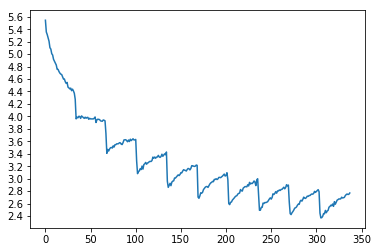

In [36]:
plot_losses = trainIters(train_loader, encoder, decoder, n_iters=10, 
                         print_every=50, plot_every=100, validate_every = 500, learning_rate=0.001, 
                                          teacher_forcing_ratio=1)

In [37]:
plot_losses = trainIters(train_loader, encoder, decoder, n_iters=10, 
                         print_every=50, plot_every=100, validate_every = 500, learning_rate=0.001, 
                                          teacher_forcing_ratio=1)

/home/ks4841/pytorch-gpu/nlp/lib/python3.6/site-packages/ipykernel_launcher.py:477: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/ks4841/pytorch-gpu/nlp/lib/python3.6/site-packages/ipykernel_launcher.py:39: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/home/ks4841/pytorch-gpu/nlp/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: torch.range is deprecated in favor of torch.arange and will be removed in 0.5. Note that arange generates values in [start; end), not [start; end].
  if __name__ == '__main__':


0m 35s (- 5m 20s) (1 10%) 2.3107
1m 11s (- 10m 39s) (1 10%) 2.3422
1m 48s (- 16m 19s) (1 10%) 2.3571
2m 24s (- 21m 38s) (1 10%) 2.3960
3m 2s (- 27m 21s) (1 10%) 2.4258
3m 37s (- 32m 40s) (1 10%) 2.4065
4m 15s (- 38m 21s) (1 10%) 2.4188
4m 51s (- 43m 40s) (1 10%) 2.4107
5m 29s (- 49m 21s) (1 10%) 2.4443
6m 4s (- 54m 40s) (1 10%) 2.4579
Bleu  6.865203369094646
7m 19s (- 65m 53s) (1 10%) 2.4767
7m 54s (- 71m 12s) (1 10%) 2.4549
8m 32s (- 76m 56s) (1 10%) 2.4800
9m 8s (- 82m 15s) (1 10%) 2.5201
9m 46s (- 87m 58s) (1 10%) 2.5292
10m 21s (- 93m 17s) (1 10%) 2.5378
10m 59s (- 98m 55s) (1 10%) 2.5319
11m 34s (- 104m 14s) (1 10%) 2.5387
12m 12s (- 109m 55s) (1 10%) 2.5666
12m 48s (- 115m 14s) (1 10%) 2.5464
Bleu  6.956523700603462
14m 2s (- 126m 25s) (1 10%) 2.5484
14m 38s (- 131m 44s) (1 10%) 2.5543
15m 16s (- 137m 27s) (1 10%) 2.5883
15m 51s (- 142m 46s) (1 10%) 2.5577
16m 29s (- 148m 27s) (1 10%) 2.5939
17m 5s (- 153m 47s) (1 10%) 2.6072
17m 43s (- 159m 28s) (1 10%) 2.6405
18m 18s (- 164m 47

KeyboardInterrupt: 

In [38]:
plot_losses = trainIters(train_loader, encoder, decoder, n_iters=10, 
                         print_every=50, plot_every=100, validate_every = 500, learning_rate=0.0001, 
                                          teacher_forcing_ratio=1)

/home/ks4841/pytorch-gpu/nlp/lib/python3.6/site-packages/ipykernel_launcher.py:477: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/ks4841/pytorch-gpu/nlp/lib/python3.6/site-packages/ipykernel_launcher.py:39: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/home/ks4841/pytorch-gpu/nlp/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: torch.range is deprecated in favor of torch.arange and will be removed in 0.5. Note that arange generates values in [start; end), not [start; end].
  if __name__ == '__main__':


0m 35s (- 5m 19s) (1 10%) 2.2659
1m 10s (- 10m 37s) (1 10%) 2.2432
1m 48s (- 16m 13s) (1 10%) 2.2702
2m 23s (- 21m 30s) (1 10%) 2.2299
3m 1s (- 27m 10s) (1 10%) 2.1893
3m 36s (- 32m 27s) (1 10%) 2.2344
4m 14s (- 38m 6s) (1 10%) 2.2315
4m 49s (- 43m 24s) (1 10%) 2.2097
5m 27s (- 49m 3s) (1 10%) 2.1909
6m 2s (- 54m 20s) (1 10%) 2.1975
Bleu  6.960126626842421
7m 16s (- 65m 29s) (1 10%) 2.1914
7m 51s (- 70m 46s) (1 10%) 2.2174
8m 29s (- 76m 27s) (1 10%) 2.1851
9m 5s (- 81m 46s) (1 10%) 2.2174
9m 42s (- 87m 26s) (1 10%) 2.2180
10m 18s (- 92m 45s) (1 10%) 2.2205
10m 56s (- 98m 28s) (1 10%) 2.1849
11m 31s (- 103m 46s) (1 10%) 2.2021
12m 9s (- 109m 25s) (1 10%) 2.1927
12m 44s (- 114m 42s) (1 10%) 2.2078
Bleu  7.116369505133828
13m 59s (- 125m 53s) (1 10%) 2.1861
14m 34s (- 131m 10s) (1 10%) 2.1669
15m 12s (- 136m 53s) (1 10%) 2.1796
15m 47s (- 142m 11s) (1 10%) 2.2050
16m 25s (- 147m 50s) (1 10%) 2.1495
17m 0s (- 153m 7s) (1 10%) 2.1621
17m 38s (- 158m 48s) (1 10%) 2.1933
18m 14s (- 164m 6s) (

KeyboardInterrupt: 

### Evaluate the final version on the test set

In [ ]:
input_lang_t, output_lang_t, pairs_t = prepareData(en_loc+'/test.tok.vi', en_loc+'/test.tok.en', 
                                                   embedding_in = embeddings_vi,
                                                   embedding_out = embeddings_en,
                                                   num_sent=None)

test_dataset = VocabDataset(pairs_t, input_lang.word2index, output_lang.word2index)
# 1 batch input dimension: num_sentences x max sentence length
# 1 batch: source_sentences, target_sentences, source_lengths, target_lengths
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=BATCH_SIZE,
                                           collate_fn=vocab_collate_func,
                                           shuffle=False)

validate(encoder, decoder, test_loader)